<a href="https://colab.research.google.com/github/harsha5428/LLM/blob/main/Assign3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
from google.colab import files
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install datasets matplotlib seaborn pandas transformers torch vaderSentiment
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [22]:
# Download necessary data for tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
class ClimateSentimentAnalysis:
    def __init__(self, model_directory=None):
        self.ds = load_dataset("climatebert/climate_detection")
        self.train_df = self.ds["train"].to_pandas()
        self.test_df = self.ds["test"].to_pandas()
        self.tokenizer = None
        self.model = None
        self.model_directory = model_directory or './saved_model'

        # Check if the directory exists, if not, create it
        if not os.path.exists(self.model_directory):
            os.makedirs(self.model_directory)
            print(f"Directory '{self.model_directory}' created.")
        else:
            print(f"Directory '{self.model_directory}' already exists.")

    def basic_stats(self):
        print("Training Data Shape:", self.train_df.shape)
        print("Test Data Shape:", self.test_df.shape)

    def class_distribution(self):
        plt.figure(figsize=(8, 6))
        sns.countplot(x='label', data=self.train_df)
        plt.title("Class Distribution in Training Data")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.show()

    def text_length_distribution(self):
        self.train_df['text_length'] = self.train_df['text'].apply(len)
        plt.figure(figsize=(8, 6))
        sns.histplot(self.train_df['text_length'], bins=50)
        plt.title("Text Length Distribution in Training Data")
        plt.xlabel("Text Length")
        plt.ylabel("Frequency")
        plt.show()

    def word_cloud(self):
        all_words = []
        for text in self.train_df['text']:
            all_words.extend(word_tokenize(text.lower()))  # Tokenize and lowercase

        # Remove stop words and punctuation for a more meaningful word cloud
        stop_words = set(STOPWORDS)
        stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])
        filtered_words = [w for w in all_words if w not in stop_words and w.isalnum()]

        freq_dist = FreqDist(filtered_words)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Training Data")
        plt.show()

    def label_specific_word_cloud(self):
        climate_words = []
        non_climate_words = []
        stop_words = set(STOPWORDS)

        for i, row in self.train_df.iterrows():
            words = word_tokenize(row['text'].lower())
            if row['label'] == 1:
                climate_words.extend(words)
            else:
                non_climate_words.extend(words)

        climate_freq = FreqDist([w for w in climate_words if w not in stop_words and w.isalnum()])
        non_climate_freq = FreqDist([w for w in non_climate_words if w not in stop_words and w.isalnum()])

        climate_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(climate_freq)
        non_climate_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(non_climate_freq)

        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(climate_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Climate Change Discussions")

        plt.subplot(1, 2, 2)
        plt.imshow(non_climate_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Non-Climate Change Discussions")

        plt.show()

    def keyword_frequency(self):
        keywords = ["climate", "warming", "emissions", "carbon", "energy", "sustainability"]

        for keyword in keywords:
            climate_count = sum(self.train_df[self.train_df['label'] == 1]['text'].str.lower().str.contains(keyword))
            non_climate_count = sum(self.train_df[self.train_df['label'] == 0]['text'].str.lower().str.contains(keyword))

            climate_percentage = (climate_count / len(self.train_df[self.train_df['label'] == 1])) * 100
            non_climate_percentage = (non_climate_count / len(self.train_df[self.train_df['label'] == 0])) * 100

            print(f"Keyword '{keyword}':")
            print(f"  - Appears in {climate_percentage:.2f}% of climate change texts")
            print(f"  - Appears in {non_climate_percentage:.2f}% of non-climate change texts")
            print("-" * 30)

In [30]:
analysis = ClimateSentimentAnalysis(model_directory='/saved_model')

Directory '/saved_model' already exists.


In [11]:
analysis.basic_stats()

Training Data Shape: (1300, 2)
Test Data Shape: (400, 2)


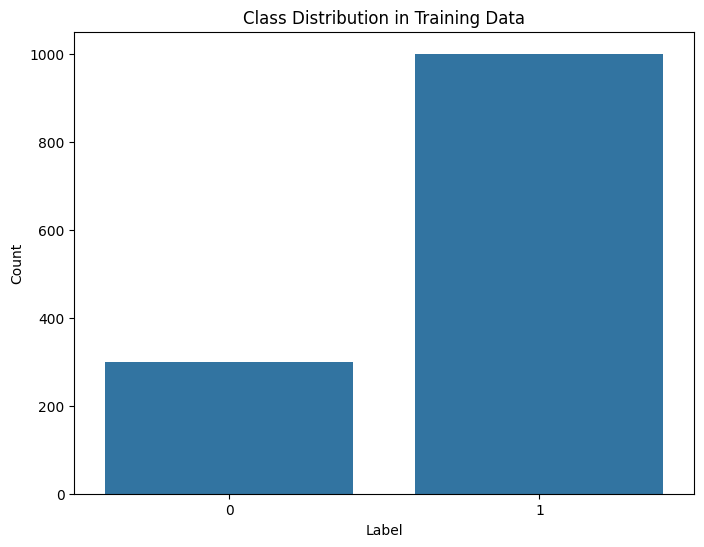

In [15]:
analysis.class_distribution()

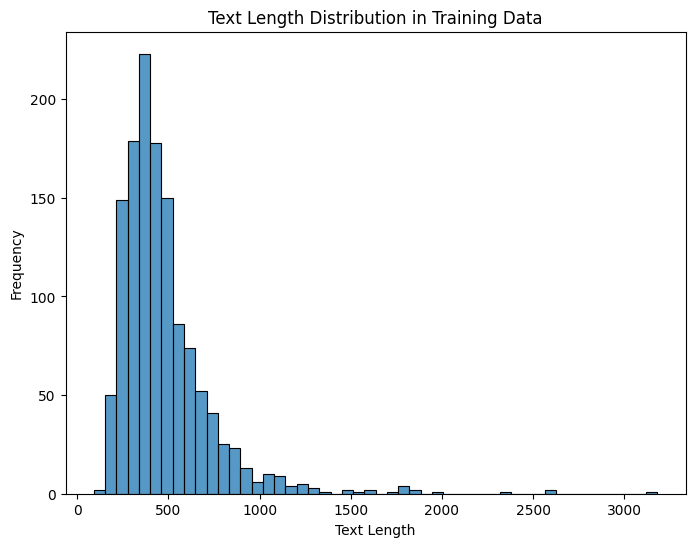

In [18]:
analysis.text_length_distribution()

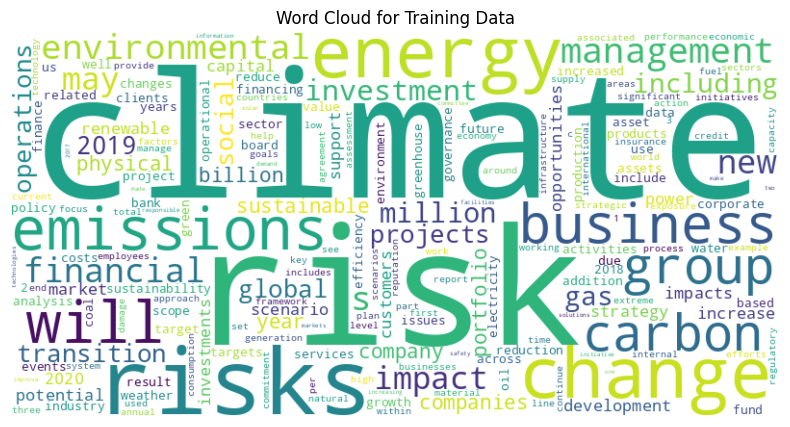

In [23]:
analysis.word_cloud()

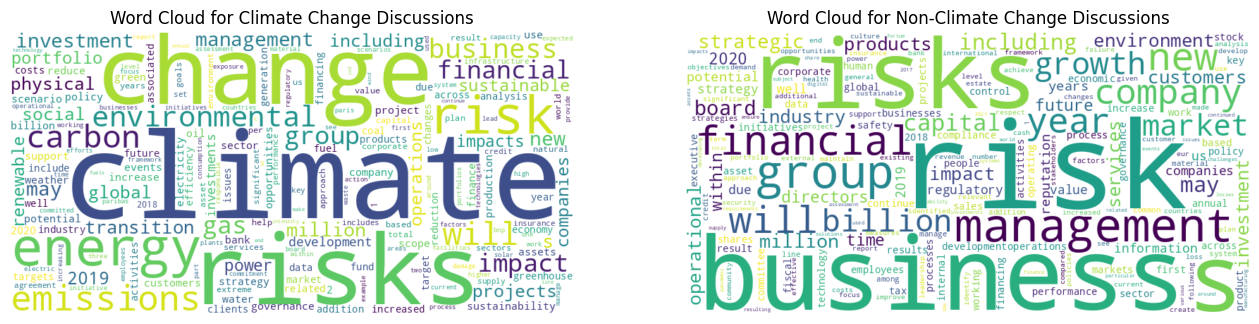

In [26]:
analysis.label_specific_word_cloud()

In [29]:
analysis.keyword_frequency()

Keyword 'climate':
  - Appears in 42.20% of climate change texts
  - Appears in 0.67% of non-climate change texts
------------------------------
Keyword 'warming':
  - Appears in 2.20% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'emissions':
  - Appears in 22.70% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'carbon':
  - Appears in 25.40% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'energy':
  - Appears in 24.80% of climate change texts
  - Appears in 2.00% of non-climate change texts
------------------------------
Keyword 'sustainability':
  - Appears in 8.40% of climate change texts
  - Appears in 1.00% of non-climate change texts
------------------------------
